# Is extraterrestrial dust a significant source of iron to the ocean?

## Motivation
- Iron is a key limiting nutrient over large regions of the ocean. Iron limitation results in incomplete utilization of surface macronutrients. Surface nutrient utilization efficiency is a key metric of the strength of biological pump, with direct influence on atmospheric CO$_2$.
- External inputs of iron to the ocean are an important control of nutrient utilization efficiency; this is particularly relevant in the Southern Ocean, where iron is strongly limiting and surface nutrients remain in excess.
- In this paper, we examine the role of iron inputs from meteoric dust, considering the contribution of this source to regional iron budgets and the impact on surface ocean productivity.


## Methods
- We use the Fe deposition field produced by Brooke et al. (2017) and conduct experiments with the ocean-ice components of the Community Earth System Model. 
- Iron deposition in the CESM ocean-ice configuration is based on dust and black carbon (BC) fields derived from a fully-coupled integration of the CESM, where dust and BC are progrostic tracers in the atmosphere. Dust and BC fields are read from a file and passed to the ocean and sea-ice component models; sea ice accumulates dust and BC, which are released upon ice melt (CITATION).  The bioavailble fraction of BC is assumed to be constant; however, the bioavailable fraction of dust-derived iron varies as a function of the coarse-to-fine dust ratio, a proxy for proximity to the dust source. Bioavailability is maximum where the coarse-to-fine ratio is zero; bioavailability declines linearly as this ratio increases until a threshold value is reached, after which bioavailability remains constant. The ocean-ice model is forced with a monthly climatology of dust and BC fields derived from three ensemble members of a WACCM simulation. Since the parameterization is nonlinear, the parameters of the iron flux dependence on dust were adjusted such that the iron flux computed on monthly-mean, ensemble-mean dust fields matches that simulated online in the coupled model.
- We added a new field passed from the atmosphere to the ocean: climatological Fe wet deposition flux rate at the surface from the WACCM/CARMA model simulation described by Brooke et al.(2017). The meteoric Fe flux was produced with horizontal resolution of 1.9x2.4 degrees and averaged from years 2004-2014 of the WACCM/CARMA simulation to create a monthly climatology.  
- Meteoric Fe is deposited directly on the ocean and sea ice where it augments the default dust and BC-derived aeolian inputs; where there is sea ice, meteoric Fe is retained by the ice and released upon melt following the same parameterization as is used for the other aerosol dust constituents. 

### Assumptions regarding bioavailability of meteoric Fe
The oxidation state of the meteoric Fe is uncertain and we consider two scenarios:

1. We treat the Fe from the meteoric fluxes as bioavailable iron (Fe$^{II}$) (e.g. Fe$_2$(SO$_4$)$_3$ (CITATION to recent lab experiments). The total flux to the ocean in this case includes that over open waters and material released seasonally from sea ice. 

1. We consider that extraterrestrial Fe is deposited in non-bioavailable form (Fe$^{III}$), but is reduced to Fe$^{II}$ by reaction with iodine in ice during both winter and sunlit periods. Under this scenario, Fe fluxes over open waters do not contribute to bioavailable iron fluxes, but all material released from sea-ice is considered bioavailable.


## References
Brooke, J., W. Feng, J. Diego Carrillo-Sanchez, G. Mann, A. James, C. Bardeen, J. Plane, Meteoric smoke deposition in the polar regions: a comparison of measurements with global atmospheric models (2017): J. Geophys. Res. Atmos., 122, https://doi.org/10.1002/2017JD027143.

In [2]:
%matplotlib inline
import os
import numpy as np
import xarray as xr

import ncar_jobqueue
import dask
import dask.distributed

import esmlab
import intake
import intake_esm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean 

import cartopy
import cartopy.crs as ccrs

import util

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
col = intake.open_esm_metadatastore(collection_input_definition='collections.yml',
                                    overwrite_existing=True)

Working on experiment: ctrl
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Working on experiment: xtfe
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 19 columns):
resource            1211 non-null object
resource_type       1211 non-null object
direct_access       1211 non-null object
description         1211 non-null object
experiment          1211 non-null object
case                1211 non-null object
component           1211 non-null object
stream              1211 non-null object
variable            1211 non-null object
date_range          1211 non-null object
ensemble            1211 non-null object
file_fullpath       1211 non-null object
file_basename       1211 non-null object
file_dirname        1211 non-null object
ctrl_branch_year    0 non-null object
year_offset         1211 non-null object
sequence_order      1211 non-null object
has_ocean_bgc       1211 non-null object
grid                1211 non-null object
dtypes: object(19)
memory usage: 179.8+ KB
Persisting xtfe-cesm-runs at : /glade/u/home/mclong/p/xtfe/intake-collecti

In [4]:
cluster = ncar_jobqueue.NCARCluster(walltime='12:00:00')
client = dask.distributed.Client(cluster)
n_workers = 9 * 2
cluster.scale(n_workers)

In [5]:
#!qstat | grep dask-worker
!squeue | grep mclong | grep dask-wor

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_ml'
           2521006       dav dask-wor   mclong PD       0:00      1 (None)


In [6]:
client

Client Scheduler: tcp://10.12.205.20:41461 Dashboard: http://10.12.205.20/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [27]:
data_vars = ['IRON_FLUX', 'photoC_TOT_zint', 'Jint_100m_DIC', 'Fe']
ds = util.open_cesm_data(col, data_vars, time_slice=slice('0020', '0032'))

xtfe: Ocean-ice hindcast, XT-Fe forcing 100% soluble
	['IRON_FLUX', 'photoC_TOT_zint', 'Jint_100m_DIC', 'Fe']
ctrl: Ocean-ice hindcast, control
	['IRON_FLUX', 'photoC_TOT_zint', 'Jint_100m_DIC', 'Fe']


In [28]:
dsann = esmlab.resample(ds, freq='ann').mean('time')
dsclm = esmlab.climatology(ds, freq='mon')

## Plot maps of annual-mean change 

In [9]:
dso = util.pop_add_cyclic(dsann)

Plot
(A) `IRON_FLUX` in 'CTRL' 
(B) Relative increase in XTFE

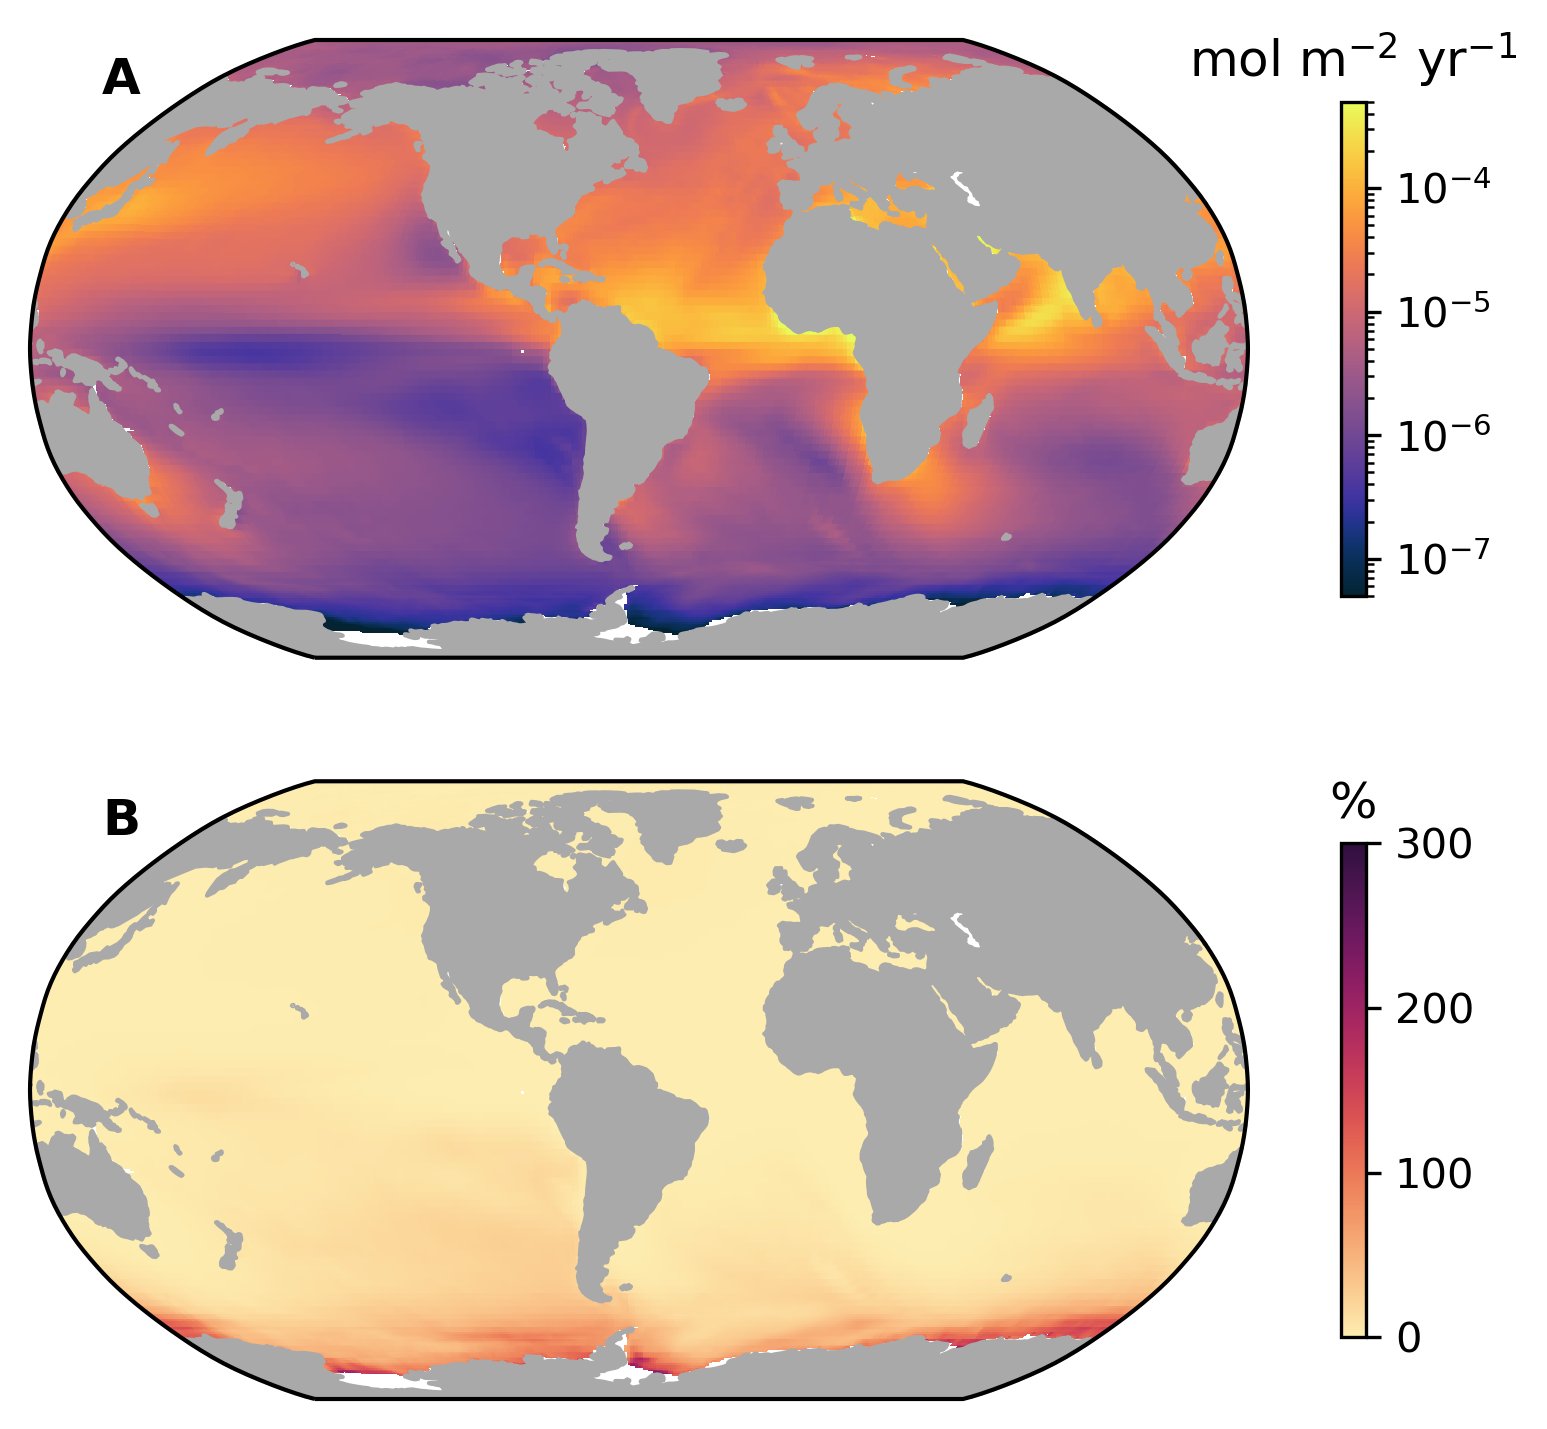

In [20]:
v = 'IRON_FLUX'

PERCENT_CHANGE = 100.*(dso[v].sel(experiment='xtfe') - 
                 dso[v].sel(experiment='ctrl')) / dso[v].sel(experiment='ctrl')

fig = plt.figure(figsize=(8, 6), dpi=300)
axs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
axs.append(ax)

pc = ax.pcolormesh(dso.TLONG, dso.TLAT, dso[v].sel(experiment='ctrl'),
                   norm=colors.LogNorm(vmin=5e-8, vmax=5e-4),
                   cmap=cmocean.cm.thermal, 
                   transform=ccrs.PlateCarree())

ax.set_global() 
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face',
                                        facecolor='darkgray'))
cb = plt.colorbar(pc, shrink=0.8)
cb.ax.set_title(ds[v].units)

ax = plt.subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))
axs.append(ax)

pc = ax.pcolormesh(dso.TLONG, dso.TLAT, PERCENT_CHANGE,
                   #norm=colors.LogNorm(vmin=1e-1, vmax=1e1),
                   vmin=0, vmax=300,
                   cmap=cmocean.cm.matter, 
                   transform=ccrs.PlateCarree())

ax.set_global() 
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                        edgecolor='face',
                                        facecolor='darkgray'))
cb = plt.colorbar(pc, shrink=0.8)
cb.ax.set_title('%')

util.label_map_axes(fig, axs)

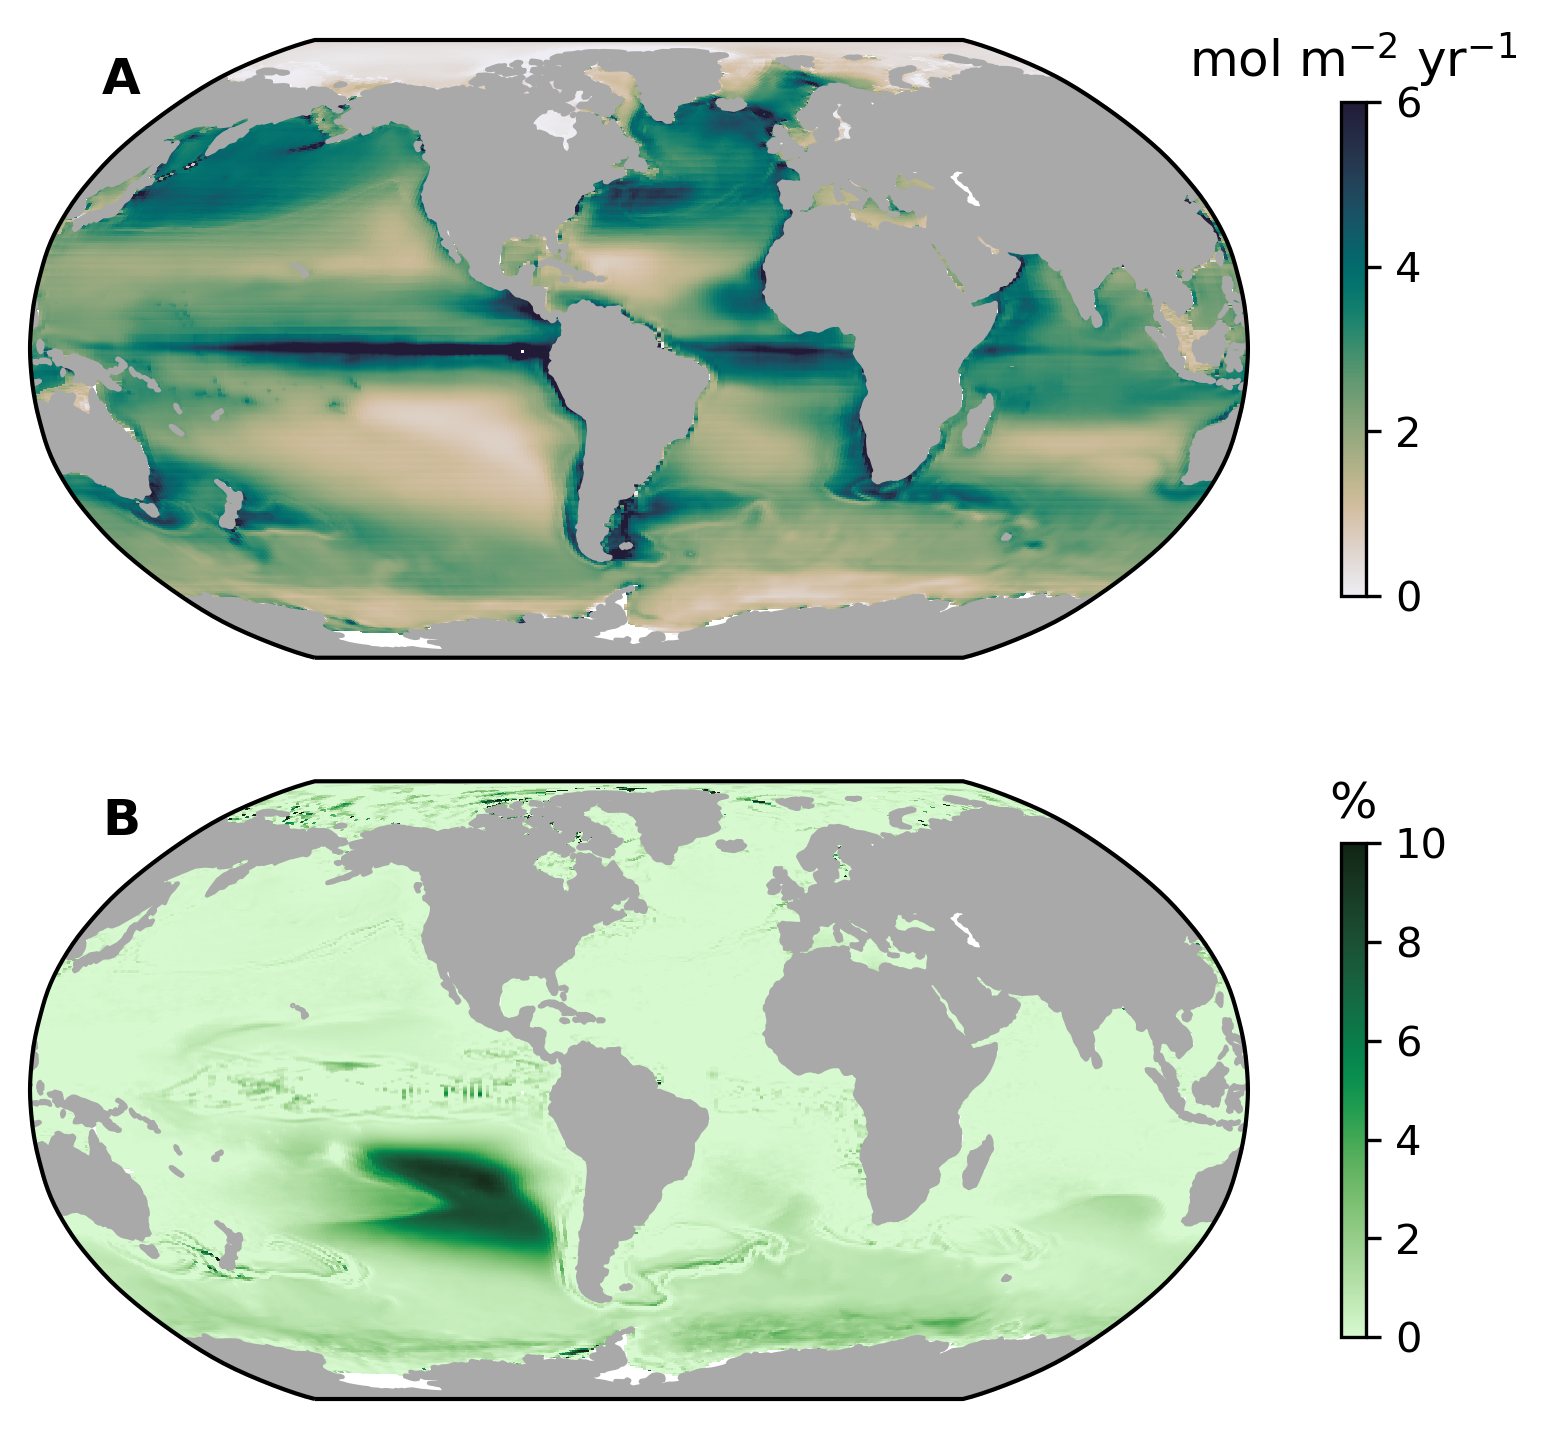

In [13]:
v = 'NCP'

PERCENT_CHANGE = 100.*(dso[v].sel(experiment='xtfe') - 
                 dso[v].sel(experiment='ctrl')) / dso[v].sel(experiment='ctrl')

fig = plt.figure(figsize=(8, 6), dpi=300)
axs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
axs.append(ax)

pc = ax.pcolormesh(dso.TLONG, dso.TLAT, dso[v].sel(experiment='ctrl'),
                   vmin=0., vmax=6,
                   cmap=cmocean.cm.rain, 
                   transform=ccrs.PlateCarree())

ax.set_global() 
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face',
                                        facecolor='darkgray'))
cb = plt.colorbar(pc, shrink=0.8)
cb.ax.set_title(ds[v].units)

ax = plt.subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))
axs.append(ax)

pc = ax.pcolormesh(dso.TLONG, dso.TLAT, PERCENT_CHANGE,
                   vmin=0, vmax=10,
                   cmap=cmocean.cm.algae, 
                   transform=ccrs.PlateCarree())

ax.set_global() 
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                        edgecolor='face',
                                        facecolor='darkgray'))
cb = plt.colorbar(pc, shrink=0.8)
cb.ax.set_title('%')

util.label_map_axes(fig, axs)

In [ ]:
dsza = dsann.isel(nlat=slice(0,187)).mean('nlon').compute()

Fe_diff = (dsza.Fe.sel(experiment='xtfe') - dsza.Fe.sel(experiment='ctrl'))

Worker tcp://10.12.205.13:44454 restart in Job 2521016. This can be due to memory issue.
Worker tcp://10.12.205.28:39516 restart in Job 2521019. This can be due to memory issue.


In [ ]:
Fe_diff.plot()